In [ ]:
import sys
sys.path.append("../")

In [203]:
import math

from monai.transforms import (
    Rand3DElasticd,
    RandAdjustContrastd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandScaleIntensityd,
)

import matplotlib.pyplot as plt

import numpy as np

from custom_transforms import SimulateLowResolutiond
from datamodule import DataModule

In [204]:
dm = DataModule(
    num_labels_with_bg=14,
    supervised_dir="/mnt/HDD2/flare2022/datasets/FLARE2022/Training/FLARE22_LabeledCase50",
    val_ratio=0.2,
    max_workers=1,
    crop_num_samples=1,
    batch_size=1,
    ds_cache_type=None,
    roi_size=(128, 128, 64),
)

dm.setup("validate")

# first_train = dm.train_ds[0]
first_val = dm.val_ds[0]

In [205]:
# print(first_train[0]['image'][:,:,23].size())
# a = torch.squeeze(first_train[0]['image'])
# print(a.size())
# print(first_train[0]['image'])
# first_train[0]['image_transforms']


In [206]:
np.random.seed(42)
max_cols = 5
slices = np.random.randint(0, 64, max_cols)
def plot_images(batch, title="Original Image"):
    # Visualizing train and validation images

    img = batch['image'].squeeze()
    label = batch['label'].squeeze()


    # slices = [1, 2, 3]


    # img = torch.squeeze(first_val['image'])
    # label = torch.squeeze(first_val['label'])

    img = img[:,:,slices]
    label = label[:,:,slices]

    # print(img.shape,label.shape)

    max_rows = 2

    fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
    for idx in range(max_cols):
        axes[0, idx].axis("off") 
        axes[0, idx].set_title('Image Slice'+str(idx+1))
        axes[0 ,idx].imshow(img[:,:,idx], cmap="gray")
    for idx in range(max_cols):    
        axes[1, idx].axis("off")
        axes[1, idx].set_title('Label Slice'+str(idx+1))
        axes[1, idx].imshow(label[:,:,idx], cmap="tab20b")

    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.show()

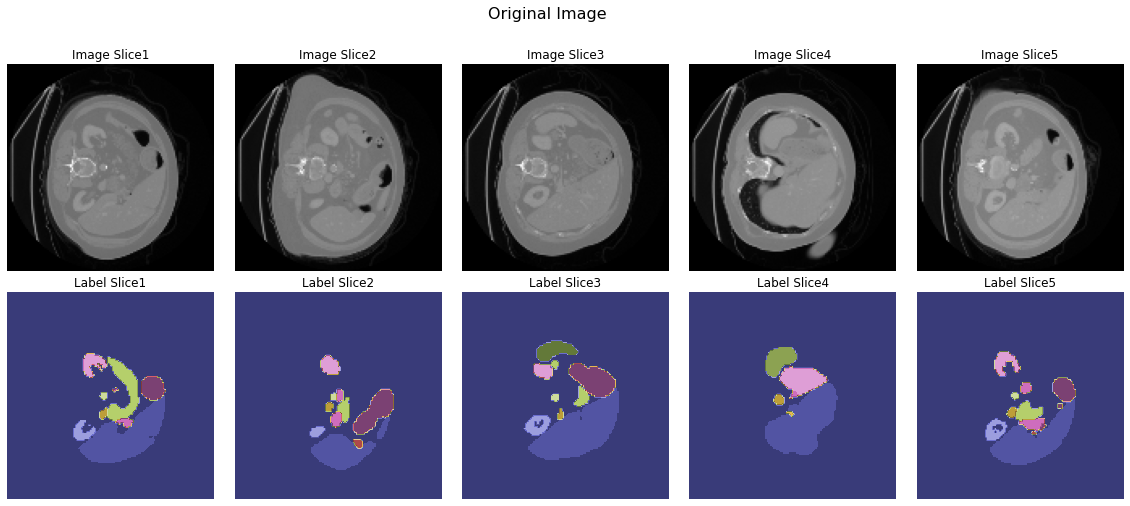

In [207]:
plot_images(first_val)

In [208]:
rand_elastic_transform = Rand3DElasticd(
                    keys=dm._dict_keys,
                    sigma_range=(5, 7),
                    magnitude_range=(20, 30),
                    padding_mode="zeros",
                    # rotate_range=(math.pi / 12, math.pi / 12, math.pi / 12),
                    # scale_range=((0.85, 1.25), (0.85, 1.25), (0.85, 1.25)),
                    prob=1,
                    mode=("bilinear", "nearest"),
                )

In [209]:
elastic_val = rand_elastic_transform(first_val)

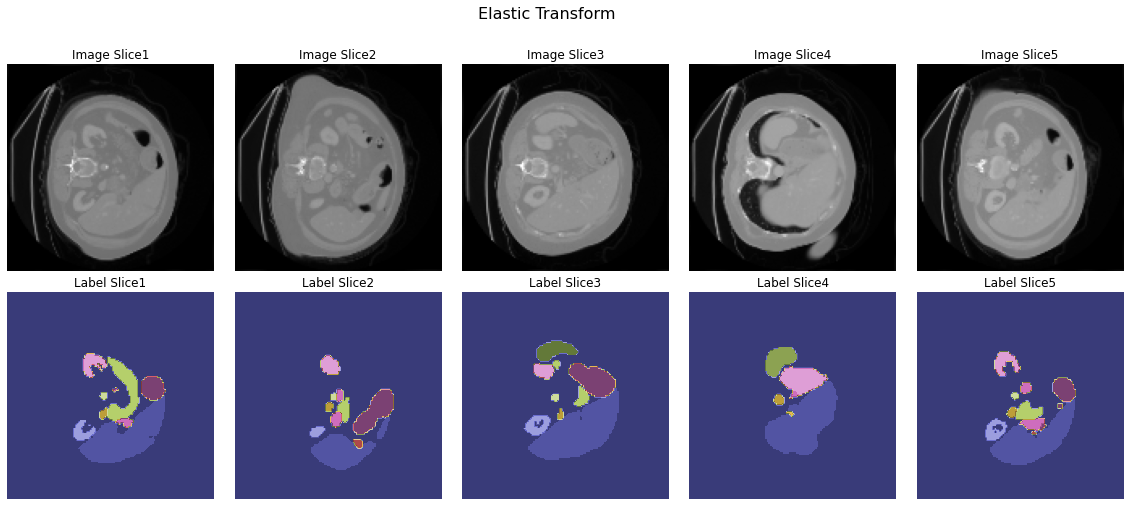

In [210]:
plot_images(elastic_val, "Elastic Transform")

In [211]:
rand_gaussian_noise = RandGaussianNoised(
                            keys="image",
                            prob=1,
                        )

In [212]:
noise_val = rand_gaussian_noise(elastic_val)

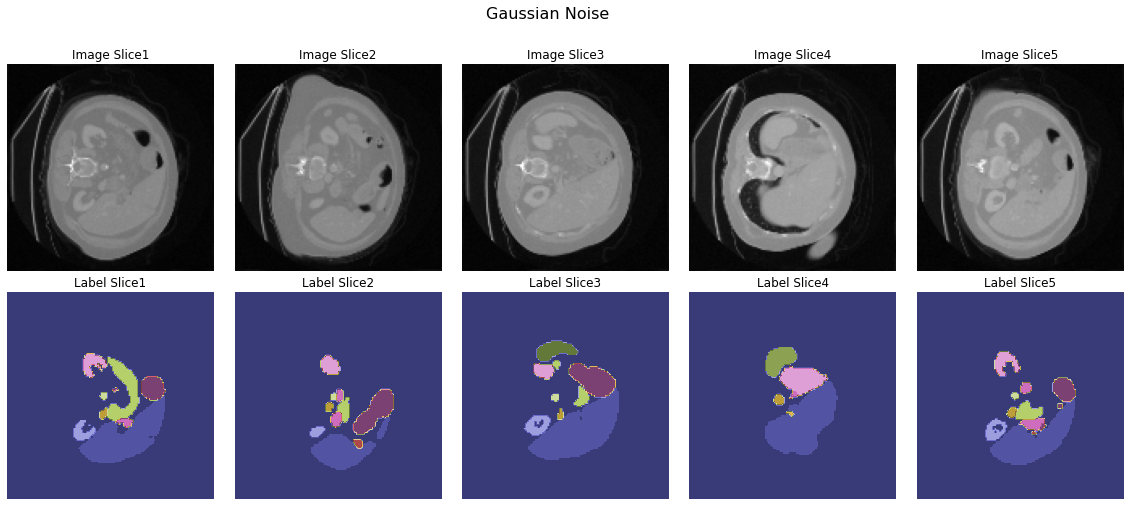

In [213]:
plot_images(noise_val, "Gaussian Noise")


In [214]:
rand_gaussian_smooth = RandGaussianSmoothd(
                        keys="image",
                        sigma_x=(0.5, 1.5),
                        sigma_y=(0.5, 1.5),
                        sigma_z=(0.5, 1.5),
                        prob=1,
                    )

In [215]:
smooth_val = rand_gaussian_smooth(noise_val)

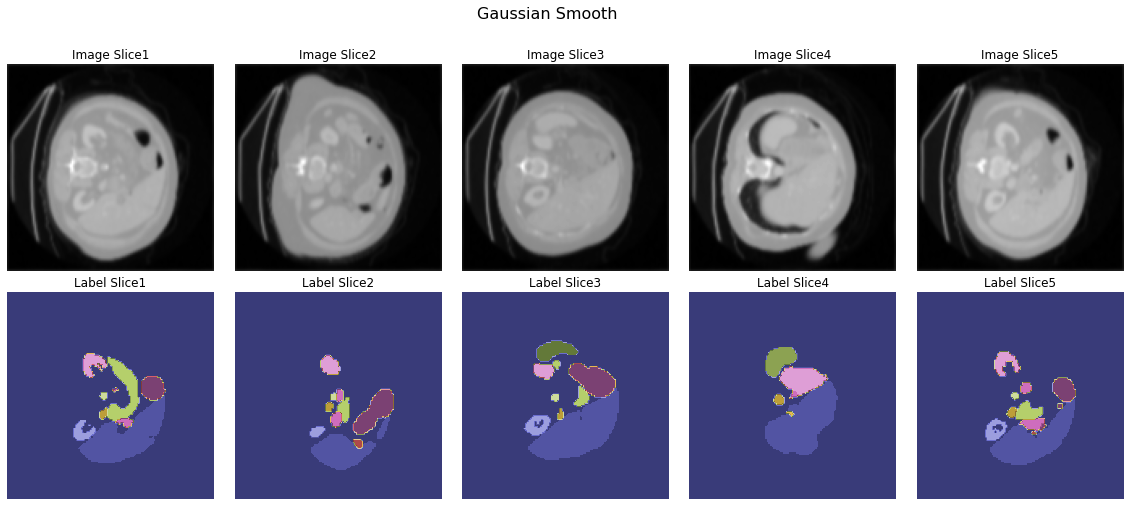

In [216]:
plot_images(smooth_val, "Gaussian Smooth")

In [217]:
rand_scale_intensity = RandScaleIntensityd(keys="image", factors=(0.7, 1.3), prob=1)

In [218]:
intensity_val = rand_scale_intensity(smooth_val)

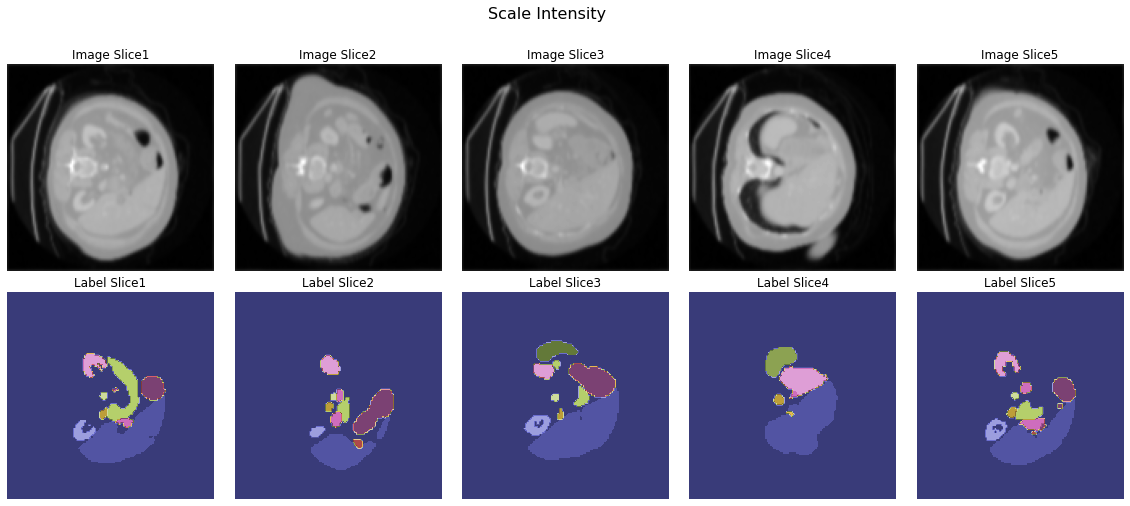

In [219]:
plot_images(intensity_val, "Scale Intensity")

In [220]:
rand_adjust_contrast = RandAdjustContrastd(keys="image", gamma=(0.65, 1.5), prob=1)

In [221]:
contrast_val = rand_adjust_contrast(intensity_val)

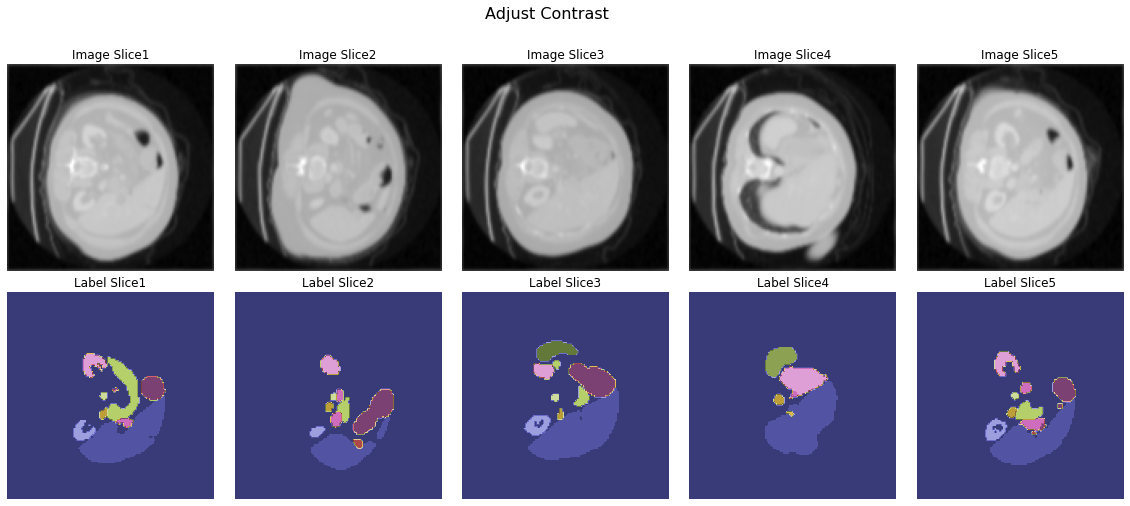

In [222]:
plot_images(contrast_val, "Adjust Contrast")

In [223]:
sim_low_res = SimulateLowResolutiond(keys="image", zoom_range=0.5, prob=1)

In [224]:
low_res_val = sim_low_res(first_val)

In [225]:
sim_low_res._scale

AttributeError: 'SimulateLowResolutiond' object has no attribute '_scale'

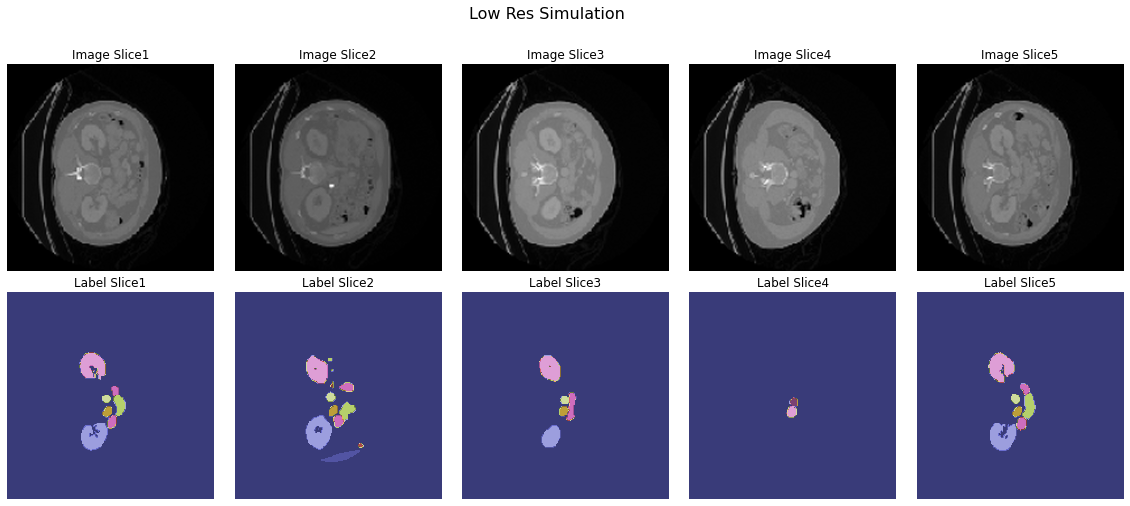

In [ ]:
plot_images(low_res_val, "Low Res Simulation")

In [49]:
from matplotlib import pyplot as plt
import numpy as np
import nibabel as nib

In [133]:
file_path = "../datasets/FLARE2022/Training/FLARE22_LabeledCase50/labels/FLARE22_Tr_0026.nii.gz"
seg = (
    nib
    .load(file_path)
    .get_fdata()
)

In [100]:
seg.shape

(512, 512, 104)

In [101]:
bool_img = seg.astype(bool)

In [105]:
max_plots = 4
random_slices = np.random.randint(0, bool_img.shape[-1], max_plots)

In [103]:
def plot_slices(img):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for sl, ax in zip(random_slices, axs.flat):
        ax.imshow(img[:, :, sl], cmap="gray")
        ax.set_title(f"Slice {sl}")

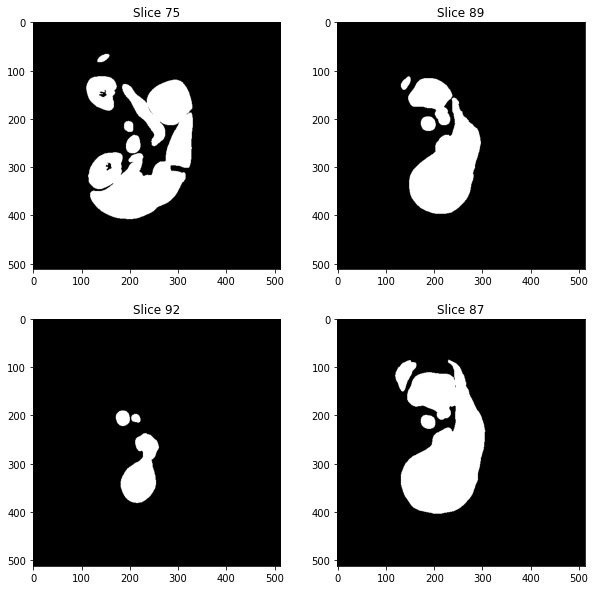

In [106]:
plot_slices(bool_img)

In [107]:
pos_indices = np.where(bool_img)

In [108]:
from scipy.spatial import ConvexHull, Delaunay

In [109]:
hull = ConvexHull(np.vstack(pos_indices).T)

In [110]:
len(hull.points)

1087301

In [111]:
triang = Delaunay(hull.points[hull.vertices])

In [112]:
# delaunay_plot_2d(triang);

In [113]:
neg_indices = np.where(~bool_img)

In [114]:
simp = triang.find_simplex(np.vstack(neg_indices).T) >=0
simp.shape

(26175675,)

In [115]:
new_bool_img = bool_img.copy()
new_bool_img[neg_indices] = simp

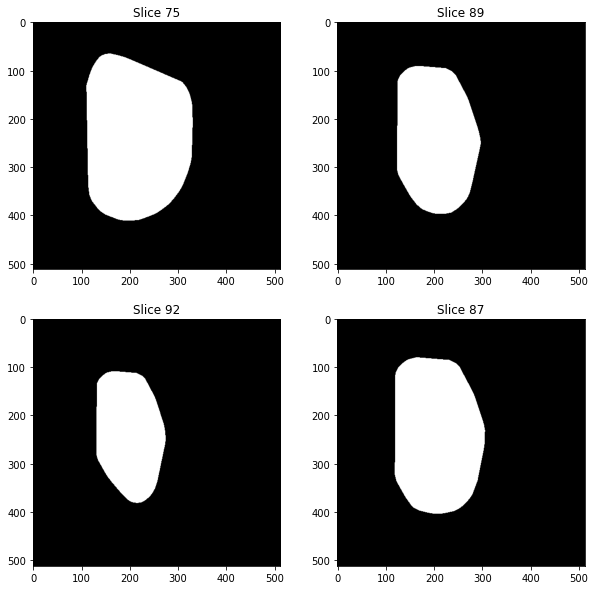

In [116]:
plot_slices(new_bool_img)

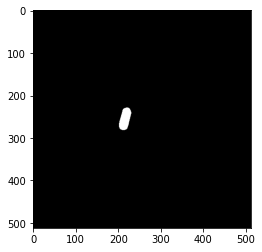

In [126]:
plt.imshow(new_bool_img[..., 50], cmap="gray");

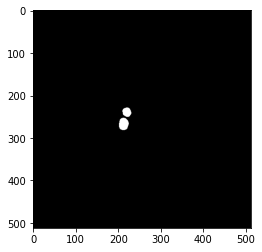

In [127]:
plt.imshow(bool_img[..., 50], cmap="gray");

In [130]:
ni_image = nib.Nifti1Image(new_bool_img.astype(np.uint8), None)

In [131]:
ni_image.get_data_dtype()

dtype('uint8')

In [135]:
import os.path

In [137]:
nib.save(ni_image, f"convex_{os.path.basename(file_path)}")

In [1]:
import os.path
from glob import glob

import numpy as np
from monai.data import DataLoader, Dataset
from monai.transforms import (
    Compose,
    HistogramNormalized,
    LoadImaged,
)

In [2]:
import sys
sys.path.append("../")

from saver import NiftiSaver

In [3]:
predict_dir = "../datasets/FLARE2022/Validation"

In [4]:
pred_image_paths = glob(os.path.join(predict_dir, "*.nii.gz"))

pred_dicts = tuple({"image": img} for img in pred_image_paths)

pred_transforms = Compose(
    (
        LoadImaged(reader="NibabelReader", keys="image"),
        # EnsureChannelFirstd(keys="image"),
        HistogramNormalized(keys="image", min=0, max=255),
    )
)

pred_ds = Dataset(pred_dicts, pred_transforms)

saver = NiftiSaver(
    f"../{os.path.basename(predict_dir)}_hist_equalized",
    output_dtype=np.uint8,
    output_postfix="hist",
    resample=False,
    mode="bicubic",
    padding_mode="zeros",
    separate_folder=False,
    print_log=True
)


dl = DataLoader(
    pred_ds,
    batch_size=1,  # Because the images do not align and are not cropped
    num_workers=4,
)

In [5]:
for batch in dl:
    image = batch["image"].squeeze()

    meta_data = {k: v[0] for k, v in batch["image_meta_dict"].items()}
    saver(image, meta_data)

2022-07-05 14:49:44,039 INFO image_writer.py:190 - writing: ../Validation_hist_equalized/FLARETs_0019_hist.nii.gz
2022-07-05 14:49:46,766 INFO image_writer.py:190 - writing: ../Validation_hist_equalized/FLARETs_0045_hist.nii.gz
2022-07-05 14:49:49,984 INFO image_writer.py:190 - writing: ../Validation_hist_equalized/FLARETs_0001_hist.nii.gz
2022-07-05 14:50:04,053 INFO image_writer.py:190 - writing: ../Validation_hist_equalized/FLARETs_0050_hist.nii.gz
2022-07-05 14:50:21,641 INFO image_writer.py:190 - writing: ../Validation_hist_equalized/FLARETs_0024_hist.nii.gz
2022-07-05 14:50:23,863 INFO image_writer.py:190 - writing: ../Validation_hist_equalized/FLARETs_0004_hist.nii.gz
2022-07-05 14:50:25,938 INFO image_writer.py:190 - writing: ../Validation_hist_equalized/FLARETs_0025_hist.nii.gz
2022-07-05 14:50:28,200 INFO image_writer.py:190 - writing: ../Validation_hist_equalized/FLARETs_0048_hist.nii.gz
2022-07-05 14:50:29,784 INFO image_writer.py:190 - writing: ../Validation_hist_equalized